<a href="https://colab.research.google.com/github/mr-rojit/movies-reviews-sentiment-analysis/blob/main/final_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import word2vec

### Exploratory Data Analysis

In [2]:
df = pd.read_csv('movies_reviews_final.csv')
df.head(10)

,user,date_review,stars,title_review,review
0,MovieWarfare,17 February 2024,1/10,Makes Morbius look like The Dark Knight\n,I would absolutely love to be in these Sony me...
1,syntory,15 February 2024,2/10,How are bad writers able to continually get h...,Look at the profiles for the writers that wrot...
2,AlsExGal,17 February 2024,2/10,"I had a bad feeling about this one, going in....",... when I saw Dakota Johnson was starring in ...
3,Orlando_Gardner,19 July 2023,9/10,Murphy is exceptional\n,You'll have to have your wits about you and yo...
4,AfricanBro,26 February 2024,9/10,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...
5,her5066,26 February 2024,10/10,This is what Hollywood needs!\n,This is what Hollywood needs. A great story wi...
6,and_mikkelsen,28 February 2024,10/10,Ladies and gentleman.. the PEAK of filmmaking...,This is the kind of movie that is impossible t...
7,parksiet,31 December 2023,4/10,Not for me\n,Poor Things simply just wasn't for me. I reall...
8,Pjtaylor-96-138044,23 January 2024,5/10,Turns out the real poor things were the audie...,Poor Things (2023) is an ostensibly feminist f...
9,ThereelscoopwithKK,12 March 2024,1/10,Pompous and Grotesque\n,A movie that's decorated as something special ...


In [3]:
df.shape

(5058, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user          5058 non-null   object
 1   date_review   5058 non-null   object
 2   stars         5058 non-null   object
 3   title_review  5058 non-null   object
 4   review        5058 non-null   object
dtypes: object(5)
memory usage: 197.7+ KB


### Transforming stars column(extracting star provied by user)

In [5]:
def extract_stars(data):
    star = int(data.split('/')[0])
    return 0 if star<=5 else 1


In [6]:
df['sentiment'] = df['stars'].apply(extract_stars)

In [7]:
df.head()

,user,date_review,stars,title_review,review,sentiment
0,MovieWarfare,17 February 2024,1/10,Makes Morbius look like The Dark Knight\n,I would absolutely love to be in these Sony me...,0
1,syntory,15 February 2024,2/10,How are bad writers able to continually get h...,Look at the profiles for the writers that wrot...,0
2,AlsExGal,17 February 2024,2/10,"I had a bad feeling about this one, going in....",... when I saw Dakota Johnson was starring in ...,0
3,Orlando_Gardner,19 July 2023,9/10,Murphy is exceptional\n,You'll have to have your wits about you and yo...,1
4,AfricanBro,26 February 2024,9/10,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...,1


In [8]:
fig = px.histogram(df,
             x='stars',
             height=500,
             title='stars distribution',
             color='stars'
            )
fig.show()

In [9]:
df = df[['review', 'sentiment']]

## Data Preprocessing

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
stop_words = set(stopwords.words('english'))
def process_text(text:str):
    # Remove "\n" characters as our text has at the very end
    text = text.replace("\n", "")

    text = re.sub(r'\d+', '', text)

    # removing shite spaces in both ends if exists
    text = text.strip()

    # Tokenize the text
    tokens = word_tokenize(text)

    table = str.maketrans('', '', string.punctuation)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    tokens = [word.translate(table) for word in tokens]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the filtered tokens back into a sentence
    filtered_text = ' '.join(tokens)

    return filtered_text

In [12]:
df['review'] = df['review'].apply(process_text)

<Axes: xlabel='sentiment', ylabel='count'>

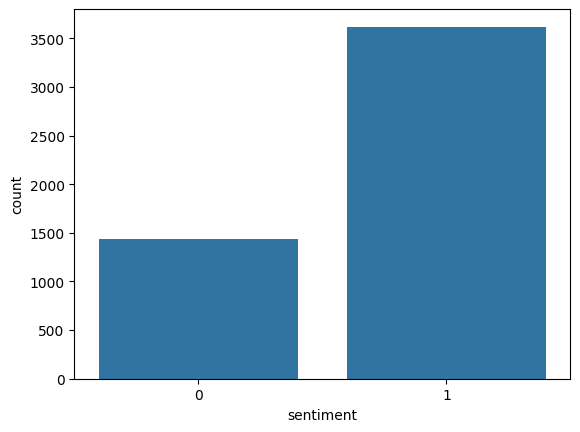

In [13]:
sns.countplot(df, x='sentiment')

In [16]:
from wordcloud import WordCloud

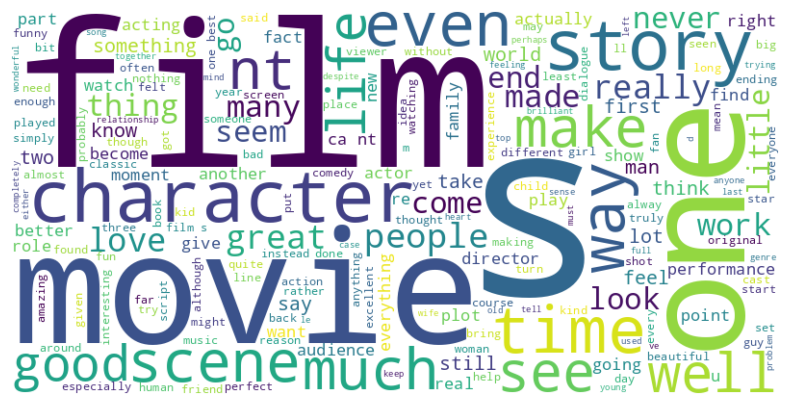

In [20]:
text_data = ' '.join(df['review'])

words = text_data.split()

word_counts = pd.Series(words).value_counts()
top_n_words = 50
top_words = word_counts.head(top_n_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve, roc_auc_score

In [22]:
X =  df['review']
y = df['sentiment']

In [23]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [24]:
## Using Smote for handling class imbalnace

In [25]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

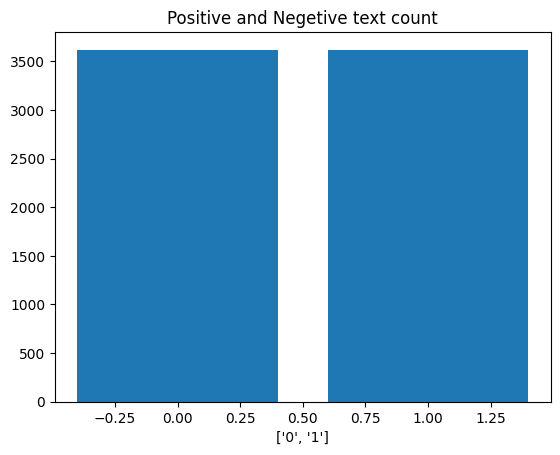

In [26]:
plt.bar(y_resampled.value_counts().keys(), y_resampled.value_counts())
plt.title('Positive and Negetive text count')
plt.xlabel(['0', '1'])
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [28]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_train, y_train)

0.9773086029992107

### Training result from logistic regression

In [29]:
logistic_train_pred = logistic_regression.predict(X_train)
print(classification_report(y_train, logistic_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2558
           1       0.97      0.98      0.98      2510

    accuracy                           0.98      5068
   macro avg       0.98      0.98      0.98      5068
weighted avg       0.98      0.98      0.98      5068



In [30]:
logistic_y_pred = logistic_regression.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_accuracy

0.9383057090239411

In [31]:
print(classification_report(y_test, logistic_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1062
           1       0.94      0.94      0.94      1110

    accuracy                           0.94      2172
   macro avg       0.94      0.94      0.94      2172
weighted avg       0.94      0.94      0.94      2172



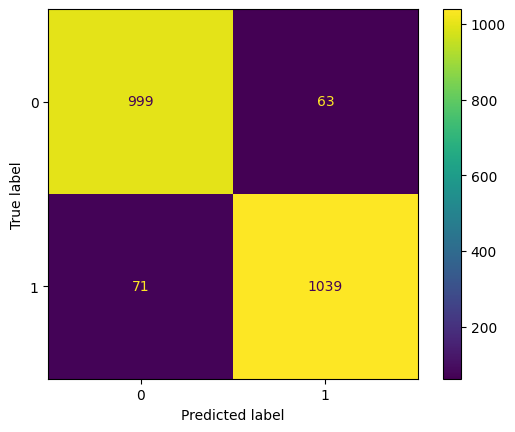

In [32]:
conf_matrix = confusion_matrix(y_test, logistic_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_regression.classes_)
disp.plot()

In [33]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

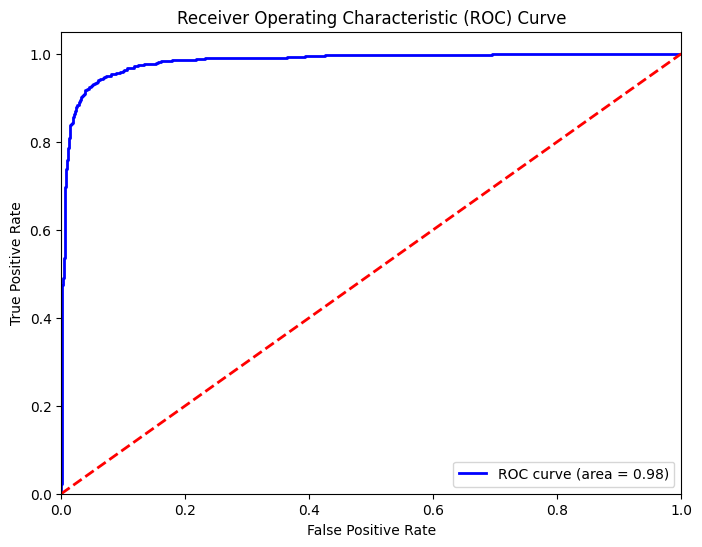

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Applying PCA for dimentionality reduction

In [35]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.fit_transform(X_test.toarray())

In [36]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_pca, y_train)

logistic_regression.score(X_train_pca, y_train)

0.8569455406471981

In [37]:
logistic_y_pred = logistic_regression.predict(X_test_pca)
logistic_accuracy = accuracy_score(y_test, logistic_y_pred)
logistic_accuracy

0.7578268876611418

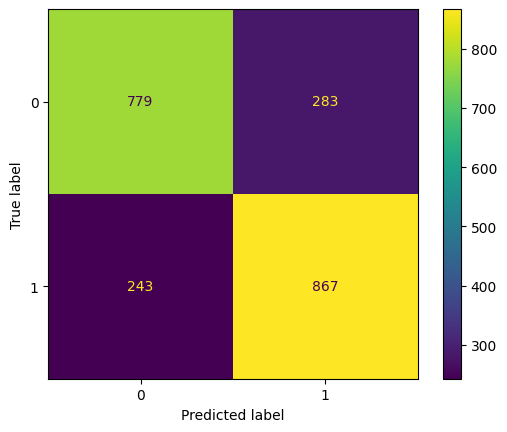

In [38]:
conf_matrix = confusion_matrix(y_test, logistic_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_regression.classes_)
disp.plot()

In [39]:
y_pred_proba = logistic_regression.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

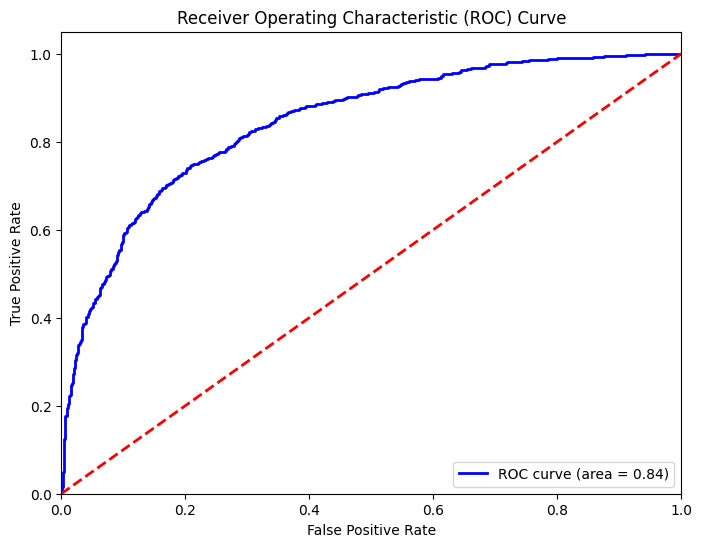

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier after PCA

In [41]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_pca, y_train)
rf_classifier.score(X_train_pca, y_train)

1.0

In [42]:
y_pred = rf_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1062
           1       0.79      0.74      0.76      1110

    accuracy                           0.77      2172
   macro avg       0.77      0.77      0.77      2172
weighted avg       0.77      0.77      0.77      2172



RFC with hyperparameter tuning

In [44]:

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# rf_classifier = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
# grid_search.fit(X_train_pca, y_train)

In [45]:
# best_params = grid_search.best_params_
# best_params

In [46]:
# best_rf_model = grid_search.best_estimator_

In [47]:
# best_rf_model.score(X_train_pca, y_train)

In [48]:
# y_pred = best_rf_model.predict(X_test_pca)
# accuracy = accuracy_score(y_test, y_pred)
# accuracy

Using ANN

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras import regularizers

In [50]:
model = Sequential()
model.add(Dense(128, activation='relu',  kernel_regularizer=regularizers.l2(0.01), input_shape=(X_test_pca.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [51]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9794 (38.26 KB)
Trainable params: 9794 (38.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
history = model.fit(X_train_pca, y_train, epochs=100, validation_data=(X_test_pca, y_test))

Epoch 1/100
159/159 [==============================] - 4s 5ms/step - loss: 1.0155 - accuracy: 0.7094 - val_loss: 0.7058 - val_accuracy: 0.7436
Epoch 2/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5965 - accuracy: 0.8129 - val_loss: 0.6230 - val_accuracy: 0.7541
Epoch 3/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5338 - accuracy: 0.8301 - val_loss: 0.6178 - val_accuracy: 0.7615
Epoch 4/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5121 - accuracy: 0.8337 - val_loss: 0.5964 - val_accuracy: 0.7652
Epoch 5/100
159/159 [==============================] - 1s 4ms/step - loss: 0.5000 - accuracy: 0.8337 - val_loss: 0.5851 - val_accuracy: 0.7684
Epoch 6/100
159/159 [==============================] - 1s 4ms/step - loss: 0.4949 - accuracy: 0.8352 - val_loss: 0.5835 - val_accuracy: 0.7735
Epoch 7/100
159/159 [==============================] - 1s 4ms/step - loss: 0.4802 - accuracy: 0.8427 - val_loss: 0.5919 - val_accuracy: 0.7689

In [54]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

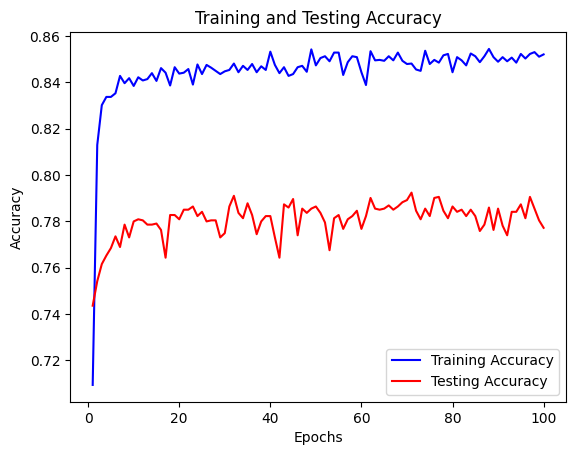

In [55]:
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
_, accuracy = model.evaluate(X_test_pca, y_test)
print("Test Accuracy:", accuracy)

68/68 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.7772
Test Accuracy: 0.7771639227867126


In [57]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

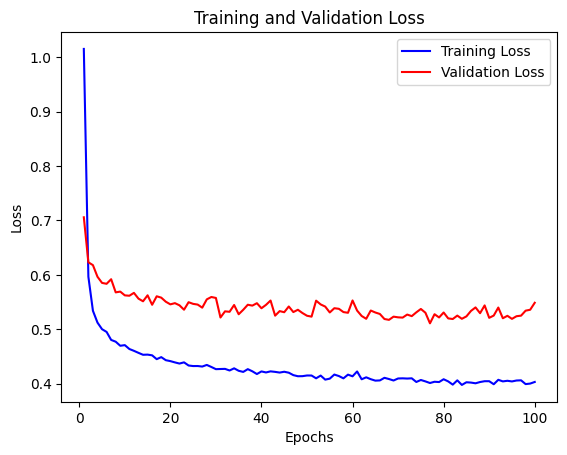

In [58]:
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
# Confusion matrix for ANN prediction

In [62]:
y_pred_proba = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_proba, axis=1)

68/68 [==============================] - 0s 2ms/step


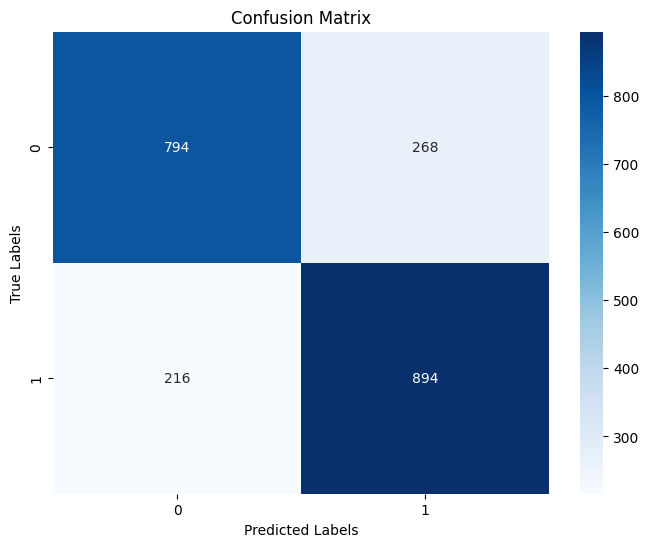

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [68]:
# Roc AUC for ANN

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])  # Assuming binary classification
roc_auc = auc(fpr, tpr)

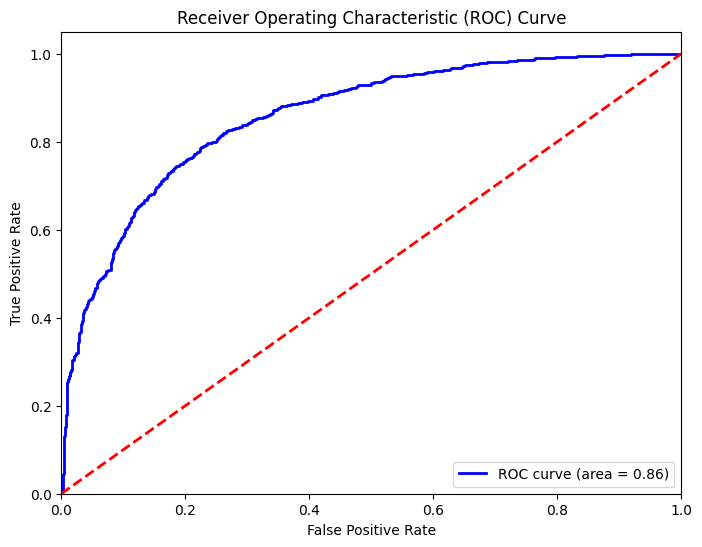

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()